In [281]:
#library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import talib
import warnings
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')

In [41]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

In [3]:
#data imports
volumes = pd.read_csv('Data/stock_volumes.csv', index_col = 'date', parse_dates = True)
prices = pd.read_csv('Data/stock_prices.csv', index_col = 'date', parse_dates = True)
info = pd.read_csv('Data/stock_info.csv')
sp_listings = pd.read_csv('Data/sp500_listings.csv', index_col = 'date', parse_dates = True)

In [312]:
#select one stock
stock1 = prices[['905270']]
stock1.rename(columns = {'905270':'Price'}, inplace = True)

In [313]:
#find when stock was delisted
delist_date = sp_listings.where(sp_listings['stock'] == '905270').last_valid_index() + pd.DateOffset(1)

In [314]:
#set all values after delist date to NaN
stock1.loc[delist_date:]['Price'] = np.nan

In [315]:
#drop missing values
stock1.dropna(inplace = True)

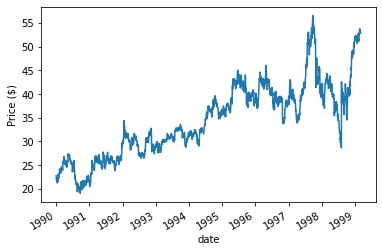

In [316]:
#EDA
stock1['Price'].plot()
plt.ylabel('Price ($)')
plt.show()

In [319]:
df = stock1[['Price']].dropna().pct_change()*100
df = df.rename(columns = {'Price': 'Return'})

<AxesSubplot:xlabel='date'>

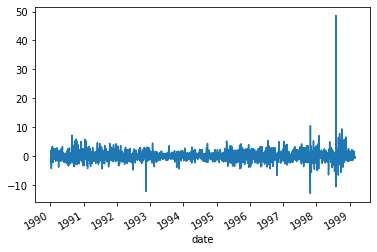

In [332]:
df['Return'].plot()

In [327]:
#train, validate, test split
train_size = int(df.shape[0]*0.7)
val_size = int(df.shape[0]*0.15)
test_size = df.shape[0] - train_size - val_size

train = df.values[:train_size]
validate = df.values[train_size:train_size + val_size]
test = df.values[train_size + val_size:]

print(f' Train size: {train_size}\n Validate size: {val_size}\n Test Size: {test_size}\n Total observations: {df.shape[0]}')

 Train size: 1620
 Validate size: 347
 Test Size: 348
 Total observations: 2315


In [328]:
#set hyperparameters
timestep = 30 #how many days of past data do we want to look at to predict future data?
batch_size = 16
neurons = 32

In [329]:
#reshape data into 3d array for keras model
train_r = TimeseriesGenerator(train, train, length = timestep, batch_size = batch_size)
val_r = TimeseriesGenerator(validate, validate, length = timestep, batch_size = batch_size)
test_r = TimeseriesGenerator(test, test, length = timestep, batch_size = batch_size)

In [330]:
#build model
model = Sequential()
model.add(LSTM(neurons, activation = 'relu', return_sequences = True, input_shape = (timestep, 1)))
model.add(LSTM(neurons, activation = 'relu', input_shape = (timestep, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 32)            4352      
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [331]:
#fit model
history = model.fit_generator(generator=train_r, verbose=2, epochs=50, validation_data=val_r)

Epoch 1/50
100/100 - 5s - loss: nan - val_loss: nan
Epoch 2/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 3/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 4/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 5/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 6/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 7/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 8/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 9/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 10/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 11/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 12/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 13/50
100/100 - 2s - loss: nan - val_loss: nan
Epoch 14/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 15/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 16/50
100/100 - 3s - loss: nan - val_loss: nan
Epoch 17/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 18/50
100/100 - 1s - loss: nan - val_loss: nan
Epoch 19/50
100/100 - 1s - loss: nan - val_loss: nan
Ep

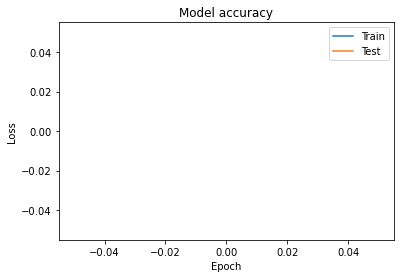

In [333]:
# Plot train vs test accuracy per epoch
plt.figure()

# Use the history metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Make it pretty
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [334]:
#Predict
trainPredict = model.predict(train_r)
valPredict = model.predict(val_r)
testPredict = model.predict(test_r)

In [335]:
#Evaluate
train_score = sklearn.metrics.r2_score(train[timestep:], trainPredict)
val_score = sklearn.metrics.r2_score(validate[timestep:], valPredict)
test_score = sklearn.metrics.r2_score(test[timestep:], testPredict)

print(f' Train Score: {train_score:.2f} \n Validation Score: {val_score:.2f}\n Test Score: {test_score:.2f}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [287]:
#X_train and X_test (dates)
df_train = df[timestep : train_size]
df_val = df[train_size + timestep: train_size + val_size]
df_test = df[train_size + val_size + timestep:]

In [276]:
#Plot train data
trainPredict = pd.DataFrame(trainPredict)
trainPredict.index = df_train.index
train_eval = pd.concat([df_train, trainPredict], axis = 1)
train_eval = train_eval.rename(columns = {'Price': 'actual', 0: 'predicted'})

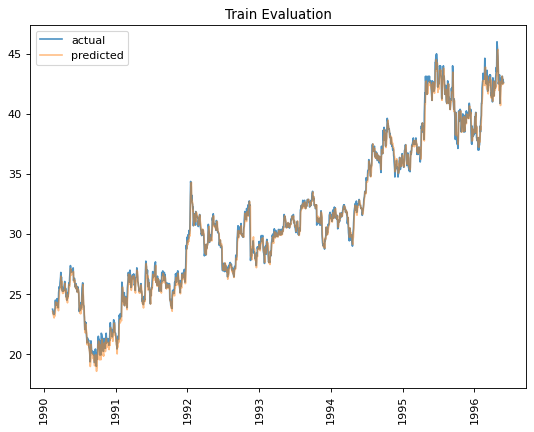

In [277]:
figure(figsize=(8, 6), dpi=80)
plt.plot(train_eval['actual'], label = 'actual', alpha = 0.8)
plt.plot(train_eval['predicted'], label = 'predicted', alpha = 0.5)
plt.title('Train Evaluation')
plt.xticks(rotation = 90)
plt.legend()

In [280]:
#Plot validation data
valPredict = pd.DataFrame(valPredict)
valPredict.index = df_val.index
val_eval = pd.concat([df_val, valPredict], axis = 1)
val_eval = val_eval.rename(columns = {'Price': 'actual', 0: 'predicted'})

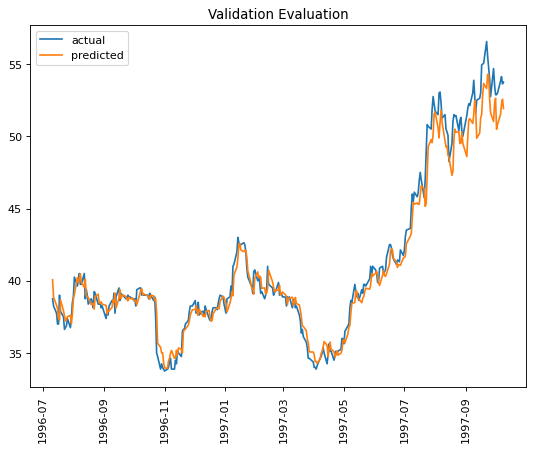

In [283]:
figure(figsize=(8, 6), dpi=80)
plt.plot(val_eval['actual'], label = 'actual')
plt.plot(val_eval['predicted'], label = 'predicted')
plt.title('Validation Evaluation')
plt.xticks(rotation = 90)
plt.legend()

In [284]:
#Plot test data
testPredict = pd.DataFrame(testPredict)
testPredict.index = df_test.index
test_eval = pd.concat([df_test, testPredict], axis = 1)
test_eval = test_eval.rename(columns = {'Price': 'actual', 0: 'predicted'})

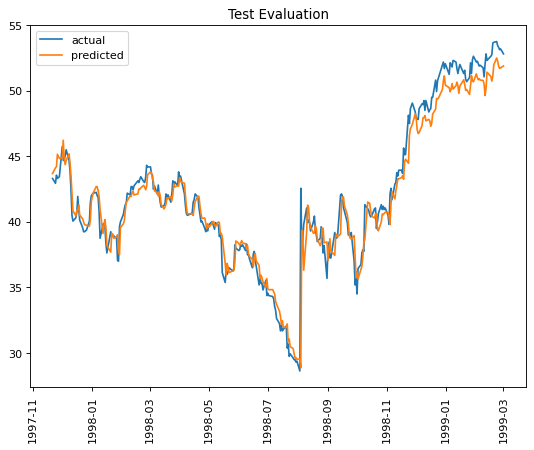

In [285]:
figure(figsize=(8, 6), dpi=80)
plt.plot(test_eval['actual'], label = 'actual')
plt.plot(test_eval['predicted'], label = 'predicted')
plt.title('Test Evaluation')
plt.xticks(rotation = 90)
plt.legend()